In [1]:
%%capture
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
# detectron2

from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional

from IPython.display import FileLink

# torch
import torch

import gc

import warnings
# Ignore "future" warnings and Data-Frame-Slicing warnings.
warnings.filterwarnings('ignore')

setup_logger()

<_Logger detectron2 (DEBUG)>

In [3]:
# import os
# import json
# import shutil

# # Define the filenames to delete
filenames_to_delete = [
    "image_49_jpg.rf.63cd2fc24dff4e784e02250324f7b1bd.jpg",
    "image_02_png.rf.cd9127e2c257989911b3146c9baf4a5b.jpg",
    "image_14_png.rf.2f0bfc71ee65c832473f54d441b25ee9.jpg",
    "image_20_jpg.rf.973ca1ac29f4801164a79d60ae4e62d0.jpg",
    "image_58_jpg.rf.d3b5cb83b255a2ef5b2f30e0d6057380.jpg",
    "image_66_jpg.rf.ce841864b8d5ba0b9728fc9c1cd0e460.jpg",
    "image_122_jpg.rf.6a0d982d8c8c3b06e9431f618d08d2b0.jpg",
    "image_136_JPG.rf.9270d1da871caedc8671ef4b95d1ab98.jpg",
    "image_05_png.rf.829300772a1cb06a8fa1c3b96b09896f.jpg",
    "image_26_png.rf.350545e8e25e7607cf047d5ad01f434a.jpg",
    "image_21_jpg.rf.c0c23e330d189f416c6248d9a6ba5051.jpg",
    "image_83_png.rf.1c92c864d678b204fc982b76740b06f7.jpg",
    "image_71_png.rf.851c2b2de9dfc7fdabe26422e79addee.jpg",
    "image_10_jpg.rf.dd89c5e542b88d5db753988b9d07ac35.jpg",
    "image_135_JPG.rf.7ab2f3e218a457df4503dd606d385df9.jpg",
    "image_05_jpg.rf.5fc7c995f75ef292cbd21cd1bdb976e8.jpg",
    "image_22_jpg.rf.0714ab8b35a1bc16c039e95005492395.jpg",
    "image_131_JPG.rf.6c45bbad715a50e6c11e2d3765fdc292.jpg",
    "image_09_jpg.rf.7cb6ab6f05147c9727b1c772b1b0a51e.jpg",
    "image_88_jpg.rf.98da547ec672180b50bd576e004ba8df.jpg",
    "image_69_jpg.rf.3af9fb4d303208641f1a27bf386219a9.jpg",
    "image_81_jpg.rf.95e1ca2dd0d2a169d3ad7276c97f5135.jpg",
    "image_118_jpg.rf.ec29eead0f3e2517543bea64847cfe52.jpg",
    "image_79_jpg.rf.17a35cc9dad677f31b751a7a7814f710.jpg",
    "image_09_png.rf.6b34b0421cb73e36828450945acf9e65.jpg",
    "image_55_jpg.rf.a2a8c47afe7ed1e2d9cab42a9d339848.jpg",
    "image_32_png.rf.4a95f9260a33a0f01244187380055c97.jpg",
    "image_06_jpg.rf.300bd5604ac00eee18ae342b8d839301.jpg",
    "image_140_JPG.rf.bc66998854a62c8d56f3b1fc2ae491a0.jpg",
    "image_138_JPG.rf.9b2c58c8afa7484b1746c7a1f370f860.jpg",
    "image_07_png.rf.b73a25ceccef1a4253ec126279075906.jpg",
    "image_16_jpg.rf.fa5f6600fb483bff18e8eabda18089c1.jpg",
    "image_23_png.rf.716fffb689187b0690d41688959c1de8.jpg",
    "image_03_png.rf.78d023f4cceb1d6ddf83a4d3c1b60bc0.jpg",
    "image_08_jpg.rf.fdb854b92c324dc1dcc63ae684b94aa0.jpg",
    "image_08_png.rf.f03b00f1ab0ff3545c22ed1c037cf099.jpg",
    "image_67_jpg.rf.b70b40b2d1eb7602edab47031c57d385.jpg",
    "image_74_jpg.rf.0fff3b7e7af6bd71947dbb602596485b.jpg",
    "image_10_png.rf.aff0a013ac0101a1dd7053b016ab5119.jpg",
    "image_114_jpg.rf.486ccc35c2986197076782d6aab25176.jpg",
    "image_109_png.rf.b55661c19295cbc7c685326dd76b87ef.jpg",
    "image_70_png.rf.1a7144e7c85b7b4999b03ffc6fa7543a.jpg",
    "image_52_jpg.rf.f200d291c808367fe5bafc66974a203a.jpg",
    "image_25_png.rf.43d9020fab96cbdf398b4b47b63b6ad2.jpg",
    "image_12_png.rf.3c2840cc1fe66ef5dcc8c561cd07cd03.jpg",
    "image_89_jpg.rf.4aab2e05cf5e4e6fbcab97524516f80b.jpg",
    "image_22_png.rf.991615f13abd827920740d3c9868d1f1.jpg",
    "image_43_png.rf.8965758f25ab5ba413c10bc2af1df695.jpg",
    "image_54_jpg.rf.5dcdda031a1410609cf306af14356cc1.jpg",
    "image_20_png.rf.7a209bc9480b4dcb7ac1b217438edd5a.jpg",
    "image_51_jpg.rf.dafc5a0f429aeab72309cd800edd9b83.jpg",
    "image_133_JPG.rf.4af044ac2029e8b64d2472a5d6caa0d5.jpg",
    "image_57_jpg.rf.ce9e9727738758d3a09d5556c0461a8b.jpg",
    "image_48_jpg.rf.5cde8616941b507be412ef841424bd8c.jpg",
    "image_137_JPG.rf.8e6336b876b74b9fd01b7c56458e2e26.jpg",
    "image_17_png.rf.434e3f3d2302dfcc070346ce122a228a.jpg",
    "image_189_png.rf.3f33d072b180008551da1366e2b110d8.jpg",
    "image_12_jpg.rf.0acee1ec8714a40dde465bb25447a4c7.jpg",
    "image_61_jpg.rf.8ef0c0c1c85b1b586ff3ca7112a2e4ea.jpg",
    "image_04_png.rf.a465fd9a620689eb639789663d69c09d.jpg",
    "image_19_png.rf.d2c857471bc9ef7c363305fe93ee063b.jpg",
    "image_24_png.rf.30f806ecf98aa5fb9638fe4631b09d6a.jpg",
    "image_07_jpg.rf.e0302bb4b49b6bc944ef1a572bda95c1.jpg",
    "image_132_JPG.rf.8195ff11d6215b63472b34a89011dbac.jpg",
    "image_15_png.rf.6948b3bd429f4e66aaf4305246a62330.jpg",
    "image_60_jpg.rf.6d612b5d04f743acce831562d930403c.jpg",
    "image_23_jpg.rf.5ef0102abe7dfab7e0832a19be920688.jpg"
]


# # Path to the image folder containing original images
# original_image_folder = '/kaggle/input/bnlad-coco/kaggle/working/train_split1/train'

# # Create a new folder for the updated images
# new_image_folder = '/kaggle/working/train_split1/train/images'
# os.makedirs(new_image_folder, exist_ok=True)

# # Copy images except those to delete
# for filename in os.listdir(original_image_folder):
#     if filename not in filenames_to_delete:
#         shutil.copy(os.path.join(original_image_folder, filename), new_image_folder)

# # Create a new JSON file with updated annotations
# json_file = '/kaggle/working/train_split1/train/images/train_coco.json'
# with open('/kaggle/input/bnlad-coco/kaggle/working/train_split1/train/train_coco.json', 'r') as f:
#     coco_data = json.load(f)

# # Remove images from the COCO JSON annotations
# coco_data['images'] = [image for image in coco_data['images'] if image['file_name'] not in filenames_to_delete]

# # Remove annotations corresponding to the deleted images
# coco_data['annotations'] = [annot for annot in coco_data['annotations'] if annot['image_id'] not in [img['id'] for img in coco_data['images']]]

# # Write the updated JSON data to a new file
# with open(json_file, 'w') as f:
#     json.dump(coco_data, f, indent=4)

# print("New COCO JSON file created.")
# print("Images copied to new folder.")

In [3]:
import json
import os
from PIL import Image

def update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json):
    # Load COCO JSON
    with open(input_coco_json, 'r') as f:
        coco_data = json.load(f)

    # Create output image folder if it doesn't exist
    if not os.path.exists(output_image_folder):
        os.makedirs(output_image_folder)

    # Initialize data for the new JSON file
    new_coco_data = {
        "info": coco_data.get("info", {}),
        "licenses": coco_data.get("licenses", []),
        "categories": coco_data.get("categories", []),
        "images": [],
        "annotations": coco_data.get("annotations", [])
    }

    # Iterate over images
    for image_info in coco_data['images']:
        image_id = image_info['id']
        width = image_info['width']
        height = image_info['height']
        file_name = image_info['file_name']

        # If width is greater than height, swap dimensions
        if width > height:
            image_info['width'] = height
            image_info['height'] = width

            # Update image file
            input_image_path = os.path.join(input_image_folder, file_name)
            output_image_path = os.path.join(output_image_folder, file_name)
            image = Image.open(input_image_path)
            image = image.transpose(Image.ROTATE_90)  # Rotate the image
            image.save(output_image_path)
        else:
            # Just copy the dimensions
            output_image_path = os.path.join(output_image_folder, file_name)
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
            os.system(f'cp "{os.path.join(input_image_folder, file_name)}" "{output_image_path}"')

        # Add updated image info to the new JSON data
        new_coco_data["images"].append(image_info)

    # Save new JSON file
    with open(output_coco_json, 'w') as f:
        json.dump(new_coco_data, f, indent=4)

if __name__ == "__main__":
    input_image_folder = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/train"
    output_image_folder = "/kaggle/working/train_split3/train/images"
    input_coco_json = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/train/train_coco.json"
    output_coco_json = "/kaggle/working/train_split3/train/images/train_coco.json"

    update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json)




In [43]:
import json
import os
from shutil import copyfile
filenames_to_delete = [
    "image_49_jpg.rf.63cd2fc24dff4e784e02250324f7b1bd.jpg",
    "image_02_png.rf.cd9127e2c257989911b3146c9baf4a5b.jpg",
    "image_14_png.rf.2f0bfc71ee65c832473f54d441b25ee9.jpg",
    "image_20_jpg.rf.973ca1ac29f4801164a79d60ae4e62d0.jpg",
    "image_58_jpg.rf.d3b5cb83b255a2ef5b2f30e0d6057380.jpg",
    "image_66_jpg.rf.ce841864b8d5ba0b9728fc9c1cd0e460.jpg",
    "image_122_jpg.rf.6a0d982d8c8c3b06e9431f618d08d2b0.jpg",
    "image_136_JPG.rf.9270d1da871caedc8671ef4b95d1ab98.jpg",
    "image_05_png.rf.829300772a1cb06a8fa1c3b96b09896f.jpg",
    "image_26_png.rf.350545e8e25e7607cf047d5ad01f434a.jpg",
    "image_21_jpg.rf.c0c23e330d189f416c6248d9a6ba5051.jpg",
    "image_83_png.rf.1c92c864d678b204fc982b76740b06f7.jpg",
    "image_71_png.rf.851c2b2de9dfc7fdabe26422e79addee.jpg",
    "image_10_jpg.rf.dd89c5e542b88d5db753988b9d07ac35.jpg",
    "image_135_JPG.rf.7ab2f3e218a457df4503dd606d385df9.jpg",
    "image_05_jpg.rf.5fc7c995f75ef292cbd21cd1bdb976e8.jpg",
    "image_22_jpg.rf.0714ab8b35a1bc16c039e95005492395.jpg",
    "image_131_JPG.rf.6c45bbad715a50e6c11e2d3765fdc292.jpg",
    "image_09_jpg.rf.7cb6ab6f05147c9727b1c772b1b0a51e.jpg",
    "image_88_jpg.rf.98da547ec672180b50bd576e004ba8df.jpg",
    "image_69_jpg.rf.3af9fb4d303208641f1a27bf386219a9.jpg",
    "image_81_jpg.rf.95e1ca2dd0d2a169d3ad7276c97f5135.jpg",
    "image_118_jpg.rf.ec29eead0f3e2517543bea64847cfe52.jpg",
    "image_79_jpg.rf.17a35cc9dad677f31b751a7a7814f710.jpg",
    "image_09_png.rf.6b34b0421cb73e36828450945acf9e65.jpg",
    "image_55_jpg.rf.a2a8c47afe7ed1e2d9cab42a9d339848.jpg",
    "image_32_png.rf.4a95f9260a33a0f01244187380055c97.jpg",
    "image_06_jpg.rf.300bd5604ac00eee18ae342b8d839301.jpg",
    "image_140_JPG.rf.bc66998854a62c8d56f3b1fc2ae491a0.jpg",
    "image_138_JPG.rf.9b2c58c8afa7484b1746c7a1f370f860.jpg",
    "image_07_png.rf.b73a25ceccef1a4253ec126279075906.jpg",
    "image_16_jpg.rf.fa5f6600fb483bff18e8eabda18089c1.jpg",
    "image_23_png.rf.716fffb689187b0690d41688959c1de8.jpg",
    "image_03_png.rf.78d023f4cceb1d6ddf83a4d3c1b60bc0.jpg",
    "image_08_jpg.rf.fdb854b92c324dc1dcc63ae684b94aa0.jpg",
    "image_08_png.rf.f03b00f1ab0ff3545c22ed1c037cf099.jpg",
    "image_67_jpg.rf.b70b40b2d1eb7602edab47031c57d385.jpg",
    "image_74_jpg.rf.0fff3b7e7af6bd71947dbb602596485b.jpg",
    "image_10_png.rf.aff0a013ac0101a1dd7053b016ab5119.jpg",
    "image_114_jpg.rf.486ccc35c2986197076782d6aab25176.jpg",
    "image_109_png.rf.b55661c19295cbc7c685326dd76b87ef.jpg",
    "image_70_png.rf.1a7144e7c85b7b4999b03ffc6fa7543a.jpg",
    "image_52_jpg.rf.f200d291c808367fe5bafc66974a203a.jpg",
    "image_25_png.rf.43d9020fab96cbdf398b4b47b63b6ad2.jpg",
    "image_12_png.rf.3c2840cc1fe66ef5dcc8c561cd07cd03.jpg",
    "image_89_jpg.rf.4aab2e05cf5e4e6fbcab97524516f80b.jpg",
    "image_22_png.rf.991615f13abd827920740d3c9868d1f1.jpg",
    "image_43_png.rf.8965758f25ab5ba413c10bc2af1df695.jpg",
    "image_54_jpg.rf.5dcdda031a1410609cf306af14356cc1.jpg",
    "image_20_png.rf.7a209bc9480b4dcb7ac1b217438edd5a.jpg",
    "image_51_jpg.rf.dafc5a0f429aeab72309cd800edd9b83.jpg",
    "image_133_JPG.rf.4af044ac2029e8b64d2472a5d6caa0d5.jpg",
    "image_57_jpg.rf.ce9e9727738758d3a09d5556c0461a8b.jpg",
    "image_48_jpg.rf.5cde8616941b507be412ef841424bd8c.jpg",
    "image_137_JPG.rf.8e6336b876b74b9fd01b7c56458e2e26.jpg",
    "image_17_png.rf.434e3f3d2302dfcc070346ce122a228a.jpg",
    "image_189_png.rf.3f33d072b180008551da1366e2b110d8.jpg",
    "image_12_jpg.rf.0acee1ec8714a40dde465bb25447a4c7.jpg",
    "image_61_jpg.rf.8ef0c0c1c85b1b586ff3ca7112a2e4ea.jpg",
    "image_04_png.rf.a465fd9a620689eb639789663d69c09d.jpg",
    "image_19_png.rf.d2c857471bc9ef7c363305fe93ee063b.jpg",
    "image_24_png.rf.30f806ecf98aa5fb9638fe4631b09d6a.jpg",
    "image_07_jpg.rf.e0302bb4b49b6bc944ef1a572bda95c1.jpg",
    "image_132_JPG.rf.8195ff11d6215b63472b34a89011dbac.jpg",
    "image_15_png.rf.6948b3bd429f4e66aaf4305246a62330.jpg",
    "image_60_jpg.rf.6d612b5d04f743acce831562d930403c.jpg",
    "image_23_jpg.rf.5ef0102abe7dfab7e0832a19be920688.jpg"
]

import json
import os
from shutil import copyfile

excluded_filenames = set(filenames_to_delete)


def update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json):
    """
    Copies images and updates COCO JSON, excluding specified files.

    Args:
        input_image_folder: Path to the input image folder.
        output_image_folder: Path to the output image folder.
        input_coco_json: Path to the input COCO JSON file.
        output_coco_json: Path to the output COCO JSON file.
    """

    # Copy image files
    for file_name in os.listdir(input_image_folder):
        if file_name in excluded_filenames:
            continue  # Skip excluded files

        input_image_path = os.path.join(input_image_folder, file_name)
        output_image_path = os.path.join(output_image_folder, file_name)
        copyfile(input_image_path, output_image_path)

    # Load and filter COCO JSON
    with open(input_coco_json, 'r') as f:
        coco_data = json.load(f)

    # Filter images
    coco_data['images'] = [image for image in coco_data['images'] if image['file_name'] not in excluded_filenames]

    # Get excluded image IDs
    excluded_image_ids = [image['id'] for image in coco_data['images'] if image['file_name'] in excluded_filenames]

    # Filter annotations
    coco_data['annotations'] = [annotation for annotation in coco_data['annotations'] if annotation['image_id'] not in excluded_image_ids]

    # Save new JSON file
    with open(output_coco_json, 'w') as f:
        json.dump(coco_data, f, indent=4)


if __name__ == "__main__":
    input_image_folder = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/train"
    output_image_folder = "/kaggle/working/train_split4/train/images"
    input_coco_json = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/train/train_coco.json"
    output_coco_json = "/kaggle/working/train_split4/train/images/train_coco.json"

    update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json)




FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/train_split4/train/images/image_37_png.rf.734410434905dd2cb51ce5d891a8e15b.jpg'

In [44]:
!cp /kaggle/working/train_split3/train/images/train_coco.json /kaggle/working/
# !ls /kaggle/input/bnlad-coco/kaggle/working/train_split1/train/*.json


In [ ]:
!rm -rf /kaggle/working/*

In [4]:
!pip install gdown

!gdown 13aLElAwaHcwigsVERZ_iR6UVWtgWboWk

Downloading...
From (original): https://drive.google.com/uc?id=13aLElAwaHcwigsVERZ_iR6UVWtgWboWk
From (redirected): https://drive.google.com/uc?id=13aLElAwaHcwigsVERZ_iR6UVWtgWboWk&confirm=t&uuid=04125b89-6071-47be-9bfe-7e62132959b7
To: /kaggle/working/unilm.zip
100%|████████████████████████████████████████| 108M/108M [00:03<00:00, 31.9MB/s]


In [5]:
# Replace '/kaggle/working/unilm.zip' with the actual path to your 'unilm.zip' file
zip_file_path = 'unilm.zip'

# Replace 'unilm' with the name of the folder where you want to unzip the contents
output_folder = 'unilm'


# Unzip the file
!unzip $zip_file_path -d $output_folder

Archive:  unilm.zip
   creating: unilm/.git/
   creating: unilm/.github/
   creating: unilm/adalm/
   creating: unilm/beats/
   creating: unilm/beit/
   creating: unilm/beit2/
   creating: unilm/beit3/
   creating: unilm/decoding/
   creating: unilm/deepnet/
   creating: unilm/deltalm/
   creating: unilm/dit/
   creating: unilm/e5/
   creating: unilm/edgelm/
   creating: unilm/infoxlm/
   creating: unilm/kosmos-1/
   creating: unilm/kosmos-2/
   creating: unilm/layoutlm/
   creating: unilm/layoutlmft/
   creating: unilm/layoutlmv2/
   creating: unilm/layoutlmv3/
   creating: unilm/layoutreader/
   creating: unilm/layoutxlm/
   creating: unilm/markuplm/
   creating: unilm/metalm/
   creating: unilm/minilm/
   creating: unilm/s2s-ft/
   creating: unilm/simlm/
   creating: unilm/speechlm/
   creating: unilm/speecht5/
   creating: unilm/storage/
   creating: unilm/textdiffuser/
   creating: unilm/trocr/
   creating: unilm/unilm/
   creating: unilm/unilm-v1/
   creating: unilm/unimim/
   cr

In [6]:
sys.path.insert(1, "/kaggle/working/unilm/layoutlmv3")


In [7]:
! sed -i 's/from collections import Iterable/from collections.abc import Iterable/' /kaggle/working/unilm/layoutlmv3/examples/object_detection/ditod/table_evaluation/data_structure.py

In [8]:
!pip install timm
!pip install  shapely

In [9]:
from examples.object_detection.ditod import add_vit_config

In [10]:
cfg = get_cfg()
# Add PointRend-specific config
add_vit_config(cfg)
# Load a config from file
cfg.merge_from_file("unilm/layoutlmv3/examples/object_detection/cascade_layoutlmv3.yaml")
print(cfg)

AUG:
  DETR: True
CACHE_DIR: 
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: False
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('publaynet_val',)
  TRAIN: ('publaynet_train',)
GLOBAL:
  HACK: 1.0
ICDAR_DATA_DIR_TEST: 
ICDAR_DATA_DIR_TRAIN: 
INPUT:
  CROP:
    ENABLED: True
    SIZE: [384, 600]
    TYPE: absolute_range
  FORMAT: RGB
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
   

**IMPORT DATASET**

In [ ]:
# !gdown 1MvjFJmDmXsyVdBLZ-zRHyEb-2dCpR4O0

In [ ]:
# !unzip -d "/kaggle/working" "Newspaper Layout Segmentation.v4i.coco-segmentation.zip"


In [ ]:
# !ls /kaggle/working/train/*.json


In [ ]:
# !mv /kaggle/working/train/_annotations.coco.json /kaggle/working/train_annotations_coco.json
# !mv /kaggle/working/train_annotations_coco.json /kaggle/working/

In [45]:
from pathlib import Path

# TRAIN_IMG_DIR = Path("/kaggle/working/train_split1/train/images")

# TRAIN_COCO_PATH = Path("/kaggle/working/train_split1/train/images/train_coco.json")

TRAIN_IMG_DIR = Path("/kaggle/working/train_split3/train/images")

TRAIN_COCO_PATH = Path("/kaggle/working/train_split3/train/images/train_coco.json")

# TEST_IMG_DIR = Path("badlad/images/test")

# TEST_METADATA_PATH = Path("badlad/badlad-test-metadata.json")

# Training output directory
OUTPUT_DIR = Path("./output_layoutlmv3")
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# Path to your pretrained model weights
PRETRAINED_PATH = Path("")

In [46]:
from datetime import datetime

# if False, model is set to `PRETRAINED_PATH` model
is_train = True

# if True, evaluate on validation dataset
is_evaluate = False

# if True, run inference on test dataset
is_inference = True

# if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_resume_training = False

# Perform augmentation
is_augment = False

SEED = 42

In [47]:
MODEL_PATH = OUTPUT_MODEL if is_train else PRETRAINED_PATH

In [48]:
with TRAIN_COCO_PATH.open() as f:
    train_dict = json.load(f)

In [49]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']

    # Convert COCO annotations to detectron2 annotations format
    data_annotations = []
    for ann in data_dict['annotations']:
        # coco format -> detectron2 format
        annot_obj = {
            # Annotation ID
            "id": ann['id'],

            # Segmentation Polygon (x, y) coords
            "gt_masks": ann['segmentation'],

            # Image ID for this annotation (Which image does this annotation belong to?)
            "image_id": ann['image_id'],

            # Category Label (0: paragraph, 1: text box, 2: image, 3: table)
            "category_id": ann['category_id'],

            "x_min": ann['bbox'][0],  # left
            "y_min": ann['bbox'][1],  # top
            "x_max": ann['bbox'][0] + ann['bbox'][2],  # left+width
            "y_max": ann['bbox'][1] + ann['bbox'][3]  # top+height
        }
        data_annotations.append(annot_obj)

    return thing_classes, images_metadata, data_annotations

In [50]:
thing_classes, images_metadata, data_annotations = organize_coco_data(
    train_dict
)

In [51]:
# thing_classes=['newspaper', 'image', 'news', 'paragraph', 'table', 'text box']

In [52]:
print(thing_classes)

['newspaper', 'image', 'news', 'paragraph', 'table', 'text box']


In [53]:
# print(data_annotations)

In [54]:
train_metadata = pd.DataFrame(images_metadata)
train_metadata = train_metadata[['id', 'file_name', 'width', 'height']]
train_metadata = train_metadata.rename(columns={"id": "image_id"})
print("train_metadata size=", len(train_metadata))
train_metadata.head(5)

train_metadata size= 683


image_id                                          file_name  width  height
0       832  image_52_png.rf.6df0aad34a2b5939a92a1f2c7588f5...   3000    4000
1       361  image_34_png.rf.b60743ea1eb1897fdcf682d8bb8944...   3000    4000
2       500  image_162_png.rf.109a457eb2efcfe76c6049c5377fc...   3120    4160
3       849  image_59_png.rf.729be4a6253ee71d15ac6ca41a0ca3...   3000    4000
4       341  image_19_png.rf.b1413d375ddf64556bf55dd83434cb...   3000    4000

In [55]:
import json

# Path to the COCO JSON file
json_file_path = '/kaggle/working/train_split3/train/images/train_coco.json'

# Load JSON data from file
with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# Access the categories array
categories = coco_data['categories']

# Iterate through categories and print ID and name
for category in categories:
    category_id = category['id']
    category_name = category['name']
    print(f"Category ID: {category_id}, Name: {category_name}")


Category ID: 0, Name: newspaper
Category ID: 1, Name: image
Category ID: 2, Name: news
Category ID: 3, Name: paragraph
Category ID: 4, Name: table
Category ID: 5, Name: text box


In [56]:
train_annot_df = pd.DataFrame(data_annotations)
train_annot_df['category_id'] = train_annot_df['category_id']
print("train_annot_df size=", len(train_annot_df))
train_annot_df.tail(20)

train_annot_df size= 127311


id                                           gt_masks  image_id  \
127291  158540  [[1644.167, 2791.667, 2997.5, 2821.667, 2939.1...       937   
127292  158541  [[1890, 100, 1895, 213.333, 2918.333, 231.667,...       937   
127293  158542  [[858.335, 1680, 1241.665, 1680, 1241.665, 172...       937   
127294  158543  [[826.665, 1405, 1239.995, 1405, 1239.995, 168...       937   
127295  158544  [[853.335, 1198.335, 1251.665, 1198.335, 1251....       937   
127296  158545  [[856.67, 968.33, 1261.67, 968.33, 1261.67, 12...       937   
127297  158546  [[860.005, 825.005, 1268.335, 825.005, 1268.33...       937   
127298  158547  [[864.995, 720.005, 1266.665, 720.005, 1266.66...       937   
127299  158548  [[876.67, 516.67, 1256.67, 516.67, 1256.67, 65...       937   
127300  158549  [[1286.665, 451.665, 1693.335, 451.665, 1693.3...       937   
127301  158550  [[1266.67, 653.33, 1681.67, 653.33, 1681.67, 1...       937   
127302  158551  [[1273.335, 1006.665, 1675.005, 1006.665, 1675...       937   
127303  158552  [[1271.665, 1236.665, 1669.995, 1236.665, 1669...       937   
127304  158553  [[1245, 1534.995, 1675, 1534.995, 1675, 1721.6...       937   
127305  158554  [[881.667, 231.667, 821.667, 1705, 1433.333, 1...       937   
127306  158555  [[480, 472.5, 835, 472.5, 837.5, 530, 772.5, 5...       937   
127307  158556  [[442.5, 547.5, 840, 552.5, 850, 630, 795, 647...       937   
127308  158557   [[852.5, 647.5, 825, 830, 470, 812.5, 475, 640]]       937   
127309  158558  [[1495, 2305, 1640, 2305, 1640, 2355, 1495, 23...       937   
127310  158559  [[2737.5, 1892.5, 2912.5, 1892.5, 2912.5, 1932...       937   

        category_id  x_min  y_min     x_max     y_max  
127291            2   1644    290  2997.333  2821.667  
127292            2   1890     98  2918.333   231.333  
127293            3    858   1680  1241.330  1720.000  
127294            3    827   1405  1240.330  1680.000  
127295            3    853   1198  1251.330  1404.670  
127296            3    857    968  1262.000  1203.000  
127297            3    860    825  1268.330   973.330  
127298            3    865    720  1266.670   828.330  
127299            5    877    517  1257.000   657.000  
127300            3   1287    452  1693.670   658.670  
127301            3   1267    653  1682.000  1013.000  
127302            3   1273   1007  1674.670  1238.670  
127303            3   1272   1237  1670.330  1540.330  
127304            3   1245   1535  1675.000  1721.670  
127305            2    822    232  1702.000  1723.667  
127306            3    468    473   838.000   543.000  
127307            3    443    548   850.500   648.000  
127308            3    470    640   852.500   830.000  
127309            5   1495   2305  1640.000  2355.000  
127310            5   2738   1893  2913.000  1933.000

In [57]:
train_annotations = pd.DataFrame(train_dict['annotations'])
train_annotations.head()

id  image_id  category_id                        bbox        area  \
0  87         1            1   [650, 103, 1253.333, 730]  914933.309   
1  88         1            5    [472, 0, 444.17, 123.33]   54779.486   
2  89         1            5   [243, 153, 313.33, 81.67]   25589.661   
3  90         1            5   [263, 250, 316.67, 76.67]   24279.089   
4  91         1            3  [253, 343, 373.33, 223.33]   83375.789   

                                        segmentation  iscrowd  
0  [[666.667, 156.667, 1873.333, 103.333, 1903.33...        0  
1  [[472.495, 0.005, 916.665, 0.005, 916.665, 123...        0  
2  [[243.335, 153.335, 556.665, 153.335, 556.665,...        0  
3  [[263.335, 249.995, 580.005, 249.995, 580.005,...        0  
4  [[253.335, 343.335, 626.665, 343.335, 626.665,...        0

In [58]:
TRAIN_SPLIT = 0.98

In [59]:
n_dataset = len(train_metadata)
n_train = int(n_dataset * TRAIN_SPLIT)
print("n_dataset", n_dataset, "n_train", n_train, "n_val", n_dataset-n_train)

np.random.seed(SEED)

inds = np.random.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]

n_dataset 683 n_train 669 n_val 14


In [60]:
DatasetCatalog.clear()


In [61]:
DATA_REGISTER_TRAINING = "my_dataset_train"
DATA_REGISTER_VALID    = "my_dataset_val"

In [62]:
def convert_coco_to_detectron2_format(
    imgdir: Path,
    metadata_df: pd.DataFrame,
    annot_df: Optional[pd.DataFrame] = None,
    target_indices: Optional[np.ndarray] = None,
):

    dataset_dicts = []
    for _, train_meta_row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
        # Iterate over each image
        image_id, filename, width, height = train_meta_row.values

        annotations = []

        # If train/validation data, then there will be annotations
        if annot_df is not None:
            for _, ann in annot_df.query("image_id == @image_id").iterrows():
                # Get annotations of current iteration's image
                class_id = ann["category_id"]
                gt_masks = ann["gt_masks"]
                bbox_resized = [
                    float(ann["x_min"]),
                    float(ann["y_min"]),
                    float(ann["x_max"]),
                    float(ann["y_max"]),
                ]

                annotation = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": gt_masks,
                    "category_id": class_id,
                }

                annotations.append(annotation)

        # coco format -> detectron2 format dict
        record = {
            "file_name": str(imgdir/filename),
            "image_id": image_id,
            "width": width,
            "height": height,
            "annotations": annotations
        }

        dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts


In [63]:
# Register Training data
if is_train:
    DatasetCatalog.register(
        DATA_REGISTER_TRAINING,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=train_inds,
        ),
    )

    # Set Training data categories
    MetadataCatalog.get(DATA_REGISTER_TRAINING).set(thing_classes=thing_classes)

    dataset_dicts_train = DatasetCatalog.get(DATA_REGISTER_TRAINING)
    metadata_dicts_train = MetadataCatalog.get(DATA_REGISTER_TRAINING)

    print("dicts training size=", len(dataset_dicts_train))
    print("################")

  0%|          | 0/683 [00:00<?, ?it/s]

dicts training size= 669
################


In [65]:
# print(dataset_dicts_train[0])

In [32]:
!gdown 1CwIgwAFY4s7Nz-ST7Al2KGL1qtrlIhFx
!gdown 1IbxaRd82hIrxPT4a1U61_g2vvE3zcRLO

Downloading...
From: https://drive.google.com/uc?id=1CwIgwAFY4s7Nz-ST7Al2KGL1qtrlIhFx
To: /kaggle/working/config.json
100%|██████████████████████████████████████████| 897/897 [00:00<00:00, 5.41MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1IbxaRd82hIrxPT4a1U61_g2vvE3zcRLO
From (redirected): https://drive.google.com/uc?id=1IbxaRd82hIrxPT4a1U61_g2vvE3zcRLO&confirm=t&uuid=56a44f0c-1814-4c21-85ed-5955d1455f27
To: /kaggle/working/model_final.pth
100%|████████████████████████████████████████| 176M/176M [00:16<00:00, 10.4MB/s]


In [87]:
torch.cuda.empty_cache()

In [67]:
if is_train:  
    # cfg = AutoConfig.from_pretrained("model_final.pth")
    # cfg = AutoConfig.from_pretrained("layoutlmv3-base")
    add_vit_config(cfg)
    cfg.merge_from_file("unilm/layoutlmv3/examples/object_detection/cascade_layoutlmv3.yaml")
#     cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    cfg.MODEL.DEVICE = "cuda" 
    cfg.MODEL.WEIGHTS = "/kaggle/working/model_final.pth"
    cfg.SOLVER.AMP.ENABLED = True
    BATCH_SIZE=1
    NOMINAL_BATCH_SIZE=16

    cfg.SOLVER.GAMMA = 0.0001
    cfg.MODEL.CONFIG_PATH="/kaggle/working/config.json"

    # Small value == Frequent save need a lot of storage.
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
    cfg.SOLVER.BASE_LR = 0.001 * BATCH_SIZE/NOMINAL_BATCH_SIZE
    cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
    cfg.SOLVER.WARMUP_ITERS = 50
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.MAX_ITER = 2000 # Set higher value, like 10000 for better results
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.SOLVER.CHECKPOINT_PERIOD = 1000
    cfg.DATASETS.TRAIN = (DATA_REGISTER_TRAINING,)
    # cfg.DATASETS.TEST=(DATA_REGISTER_TEST,)
    cfg.SOLVER.GRADIENT_ACCUMULATION_STEPS = 1
    cfg.OUTPUT_DIR = str(OUTPUT_DIR)
    
    print("creating cfg.OUTPUT_DIR -> ", cfg.OUTPUT_DIR)
    OUTPUT_DIR.mkdir(exist_ok=True)

creating cfg.OUTPUT_DIR ->  output_layoutlmv3


In [68]:
from examples.object_detection.ditod import MyTrainer

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
# Uncomment to train
trainer.train()

  0%|          | 0/683 [00:00<?, ?it/s]

[02/11 09:34:26 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| newspaper  | 0            |   image    | 6857         |    news    | 8292         |
| paragraph  | 32297        |   table    | 406          |  text box  | 62709        |
|            |              |            |              |            |              |
|   total    | 110561       |            |              |            |              |
[02/11 09:34:26 d2.data.build]: Using training sampler TrainingSampler
[02/11 09:34:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/11 09:34:26 d2.data.common]: Serializing 669 elements to byte tensors and concatenating them all ...
[02/11 09:34:27 d2.data.common]: Serialized dataset takes 19.06 MiB
[02/11 09:34:27 d2.data.build]: Making b

KeyError: "Dataset 'publaynet_val' is not registered! Available datasets are: my_dataset_train"

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to the folder containing images
image_folder = '/kaggle/working/train_split1/train/images'

# Iterate over the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Assuming images are in JPEG or PNG format
        image_path = os.path.join(image_folder, filename)
        
        # Read the image
        image = cv2.imread(image_path)
        
        # Get the dimensions of the image
        height, width, _ = image.shape
        
        # Check if width is greater than height
        if width > height:
            print(filename)

            

# **testing**

In [70]:
import json
import os
from shutil import copyfile
filenames_to_delete = [
    "image_18_png.rf.420a5fb779f38686ffb0c8850d3781be.jpg",
    "image_75_jpg.rf.38f1d8df103ec137b2e9725884ab9f0b.jpg",
    "image_139_JPG.rf.09e76cdb12a2cc7a3c7fd538a38654b2.jpg",
    "image_17_jpg.rf.87f36617099b064c4df14af59a93d74c.jpg",
    "image_01_png.rf.afd1d7ce2f8c1343e71b82ad1097ce86.jpg",
    "image_06_png.rf.540f77808bf91b56c3c0867327863c28.jpg",
    "image_72_jpg.rf.d8bd4d78b8b343f24318672d8887a806.jpg",
    "image_200_png.rf.7473b5278df88e41a6bd40191573e4bb.jpg",
    "image_16_png.rf.57a5dfeb107f24910bba08145fdd8a61.jpg"
]


def update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json):
    """
    Copies images and updates COCO JSON, excluding specified files.

    Args:
        input_image_folder (str): Path to the input image folder.
        output_image_folder (str): Path to the output image folder (will be created if it doesn't exist).
        input_coco_json (str): Path to the input COCO JSON file.
        output_coco_json (str): Path to the output COCO JSON file.
    """

    # Validate input paths
    if not os.path.exists(input_image_folder):
        raise ValueError(f"Input image folder not found: {input_image_folder}")
    if not os.path.exists(input_coco_json):
        raise ValueError(f"Input COCO JSON file not found: {input_coco_json}")

    # Convert filenames to a set for faster lookups
    excluded_filenames = set(filenames_to_delete)

    # Create the output image folder if it doesn't exist
    try:
        os.makedirs(output_image_folder, exist_ok=True)
    except Exception as e:
        print(f"Error creating output image folder: {e}")
        return

    # Copy image files with error handling
    for file_name in os.listdir(input_image_folder):
        if file_name in excluded_filenames:
            continue  # Skip excluded files

        input_image_path = os.path.join(input_image_folder, file_name)
        output_image_path = os.path.join(output_image_folder, file_name)

        try:
            copyfile(input_image_path, output_image_path)
            print(f"Copied {file_name} to {output_image_path}")
        except Exception as e:
            print(f"Error copying file {file_name}: {e}")
            continue  # Continue processing other files

    # Load and filter COCO JSON with error handling
    try:
        with open(input_coco_json, 'r') as f:
            coco_data = json.load(f)
    except Exception as e:
        print(f"Error loading COCO JSON file: {e}")
        return

    # Filter images (exclude based on filename)
    coco_data['images'] = [image for image in coco_data['images'] if image['file_name'] not in excluded_filenames]

    # Get excluded image IDs (based on filtered filenames)
    excluded_image_ids = [image['id'] for image in coco_data['images'] if image['file_name'] in excluded_filenames]

    # Filter annotations (exclude annotations associated with excluded image IDs)
    coco_data['annotations'] = [annotation for annotation in coco_data['annotations'] if annotation['image_id'] not in excluded_image_ids]

    # Save new COCO JSON file with error handling
    try:
        with open(output_coco_json, 'w') as f:
            json.dump(coco_data, f, indent=4)
            print(f"Saved updated COCO JSON to: {output_coco_json}")
    except Exception as e:
        print(f"Error saving COCO JSON file: {e}")


if __name__ == "__main__":
    input_image_folder = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/test"
    output_image_folder = "/kaggle/working/test_split4/test/images"
    input_coco_json = "/kaggle/input/bnlad-coco/kaggle/working/train_split1/test/test_coco.json"
    output_coco_json = "/kaggle/working/test_split4/test/images/test_coco.json"

    update_dimensions(input_image_folder, output_image_folder, input_coco_json, output_coco_json)




Copied image_70_jpg.rf.0956659915806b9e021d2e3de48dac45.jpg to /kaggle/working/test_split4/test/images/image_70_jpg.rf.0956659915806b9e021d2e3de48dac45.jpg
Copied image_54_png.rf.a21ae76aeba7e8ae1d0f442d7f5a11a6.jpg to /kaggle/working/test_split4/test/images/image_54_png.rf.a21ae76aeba7e8ae1d0f442d7f5a11a6.jpg
Copied image_102_jpg.rf.c633453ef2969caacbbb956af47f3d12.jpg to /kaggle/working/test_split4/test/images/image_102_jpg.rf.c633453ef2969caacbbb956af47f3d12.jpg
Copied image_14_png.rf.d250193007029e47fb53885684667e4f.jpg to /kaggle/working/test_split4/test/images/image_14_png.rf.d250193007029e47fb53885684667e4f.jpg
Copied image_81_png.rf.0e72c778538e1a7064f848d68488b351.jpg to /kaggle/working/test_split4/test/images/image_81_png.rf.0e72c778538e1a7064f848d68488b351.jpg
Copied image_41_jpg.rf.e7c4368e8173301da16b5f1f55da1dc9.jpg to /kaggle/working/test_split4/test/images/image_41_jpg.rf.e7c4368e8173301da16b5f1f55da1dc9.jpg
Copied image_92_png.rf.cb73b664c39b1d79c383adcbdd137523.jpg to

In [71]:
from pathlib import Path

TEST_IMG_DIR = Path("/kaggle/working/test_split4/test/images")


TEST_METADATA_PATH = Path("/kaggle/working/test_split4/test/images/test_coco.json")
# Training output directory
OUTPUT_DIR = Path("./output12")
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# Path to your pretrained model weights
PRETRAINED_PATH = Path("")

In [72]:
with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)

print("#### LABELS AND METADATA LOADED ####")

#### LABELS AND METADATA LOADED ####


In [73]:
thing_classes_test, images_metadata_test, _ = organize_coco_data(
    test_dict
)

In [74]:
print(thing_classes_test)


['newspaper', 'image', 'news', 'paragraph', 'table', 'text box']


In [75]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 84


image_id                                          file_name  width  height
0       650  image_69_png.rf.3e6145e8b43c09efa566a9715ab64f...   3120    4160
1       717  image_57_jpg.rf.509c011ff52dac9e654497bedbe6a6...   3072    4080
2       881  image_158_png.rf.7d140c072b5af09aebd89890f3b93...   2072    2957
3       163  image_26_png.rf.f9d75cb856342239aae515d24d30e4...   3120    4160
4       529  image_11_png.rf.19797ad5634b3e11f3bd73330b797b...   3024    4032

In [76]:
DATA_REGISTER_TEST     = "badlad_test"


In [77]:
# Register Test Inference data
DatasetCatalog.register(
    DATA_REGISTER_TEST,
    lambda: convert_coco_to_detectron2_format(
        TEST_IMG_DIR,
        test_metadata,
    )
)

# Set Test data categories
MetadataCatalog.get(DATA_REGISTER_TEST).set(
    thing_classes=thing_classes_test
)

dataset_dicts_test = DatasetCatalog.get(DATA_REGISTER_TEST)
metadata_dicts_test = MetadataCatalog.get(DATA_REGISTER_TEST)

# print("dicts valid size=", len(dataset_dicts_test))
# print("################")

  0%|          | 0/84 [00:00<?, ?it/s]

In [78]:
MODEL_PATH=Path("/kaggle/working/output_layoutlmv3/model_0001999.pth")


In [93]:
inf_cfg = get_cfg()

# config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

# inf_cfg.merge_from_file(model_zoo.get_config_file(config_name))
add_vit_config(inf_cfg)
    # Load a config from file
inf_cfg.merge_from_file("/kaggle/working/unilm/layoutlmv3/examples/object_detection/cascade_layoutlmv3.yaml")
inf_cfg.MODEL.CONFIG_PATH="/kaggle/working/config.json"
inf_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
inf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
inf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
inf_cfg.MODEL.DEVICE = "cuda"

inf_cfg.DATALOADER.NUM_WORKERS = 1  # lower this if CUDA overflow occurs
inf_cfg.MODEL.WEIGHTS = str(MODEL_PATH)
BATCH = 1 # lower this if CUDA overflow occurs
test_loader = build_detection_test_loader(inf_cfg, DATA_REGISTER_TEST, batch_size=BATCH)

  0%|          | 0/84 [00:00<?, ?it/s]

[02/11 10:38:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/11 10:38:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/11 10:38:44 d2.data.common]: Serializing 84 elements to byte tensors and concatenating them all ...
[02/11 10:38:44 d2.data.common]: Serialized dataset takes 0.01 MiB


In [94]:
ACCEPTANCE_THRESHOLD = 0.4  # for all categories


In [95]:
print(f"#### MODEL: {inf_cfg.MODEL.WEIGHTS} FOR INFERENCE ####")


#### MODEL: /kaggle/working/output_layoutlmv3/model_0001999.pth FOR INFERENCE ####


In [96]:
predictor = DefaultPredictor(inf_cfg)


[02/11 10:38:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output_layoutlmv3/model_0001999.pth ...


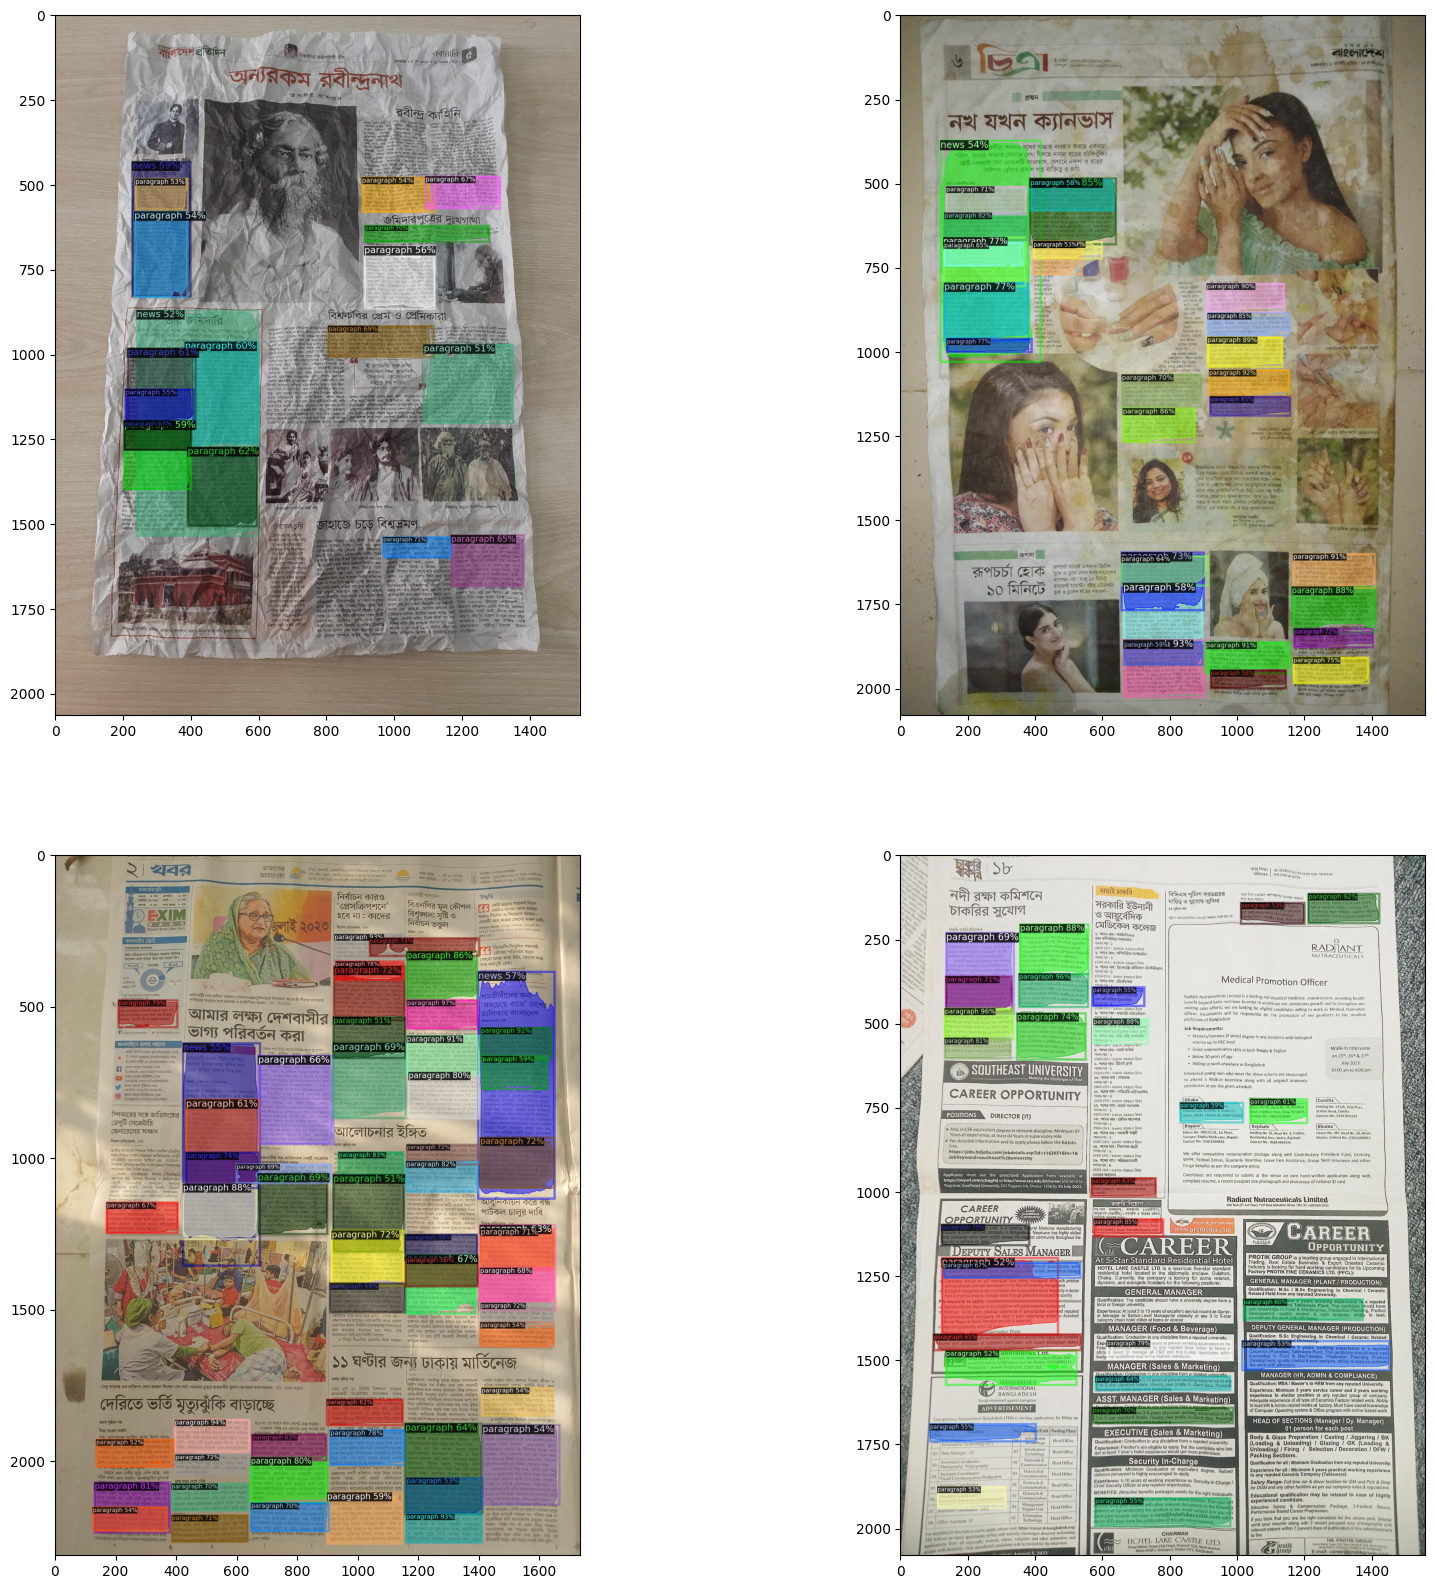

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = np.random.choice(dataset_dicts_test, NUM_TEST_SAMPLES)

for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_test, scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)